<a href="https://colab.research.google.com/github/BBoshra/A-pipeline-to-enhance-animal-vehicle-collision-analysis-in-crash-report-dataset/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pipeline
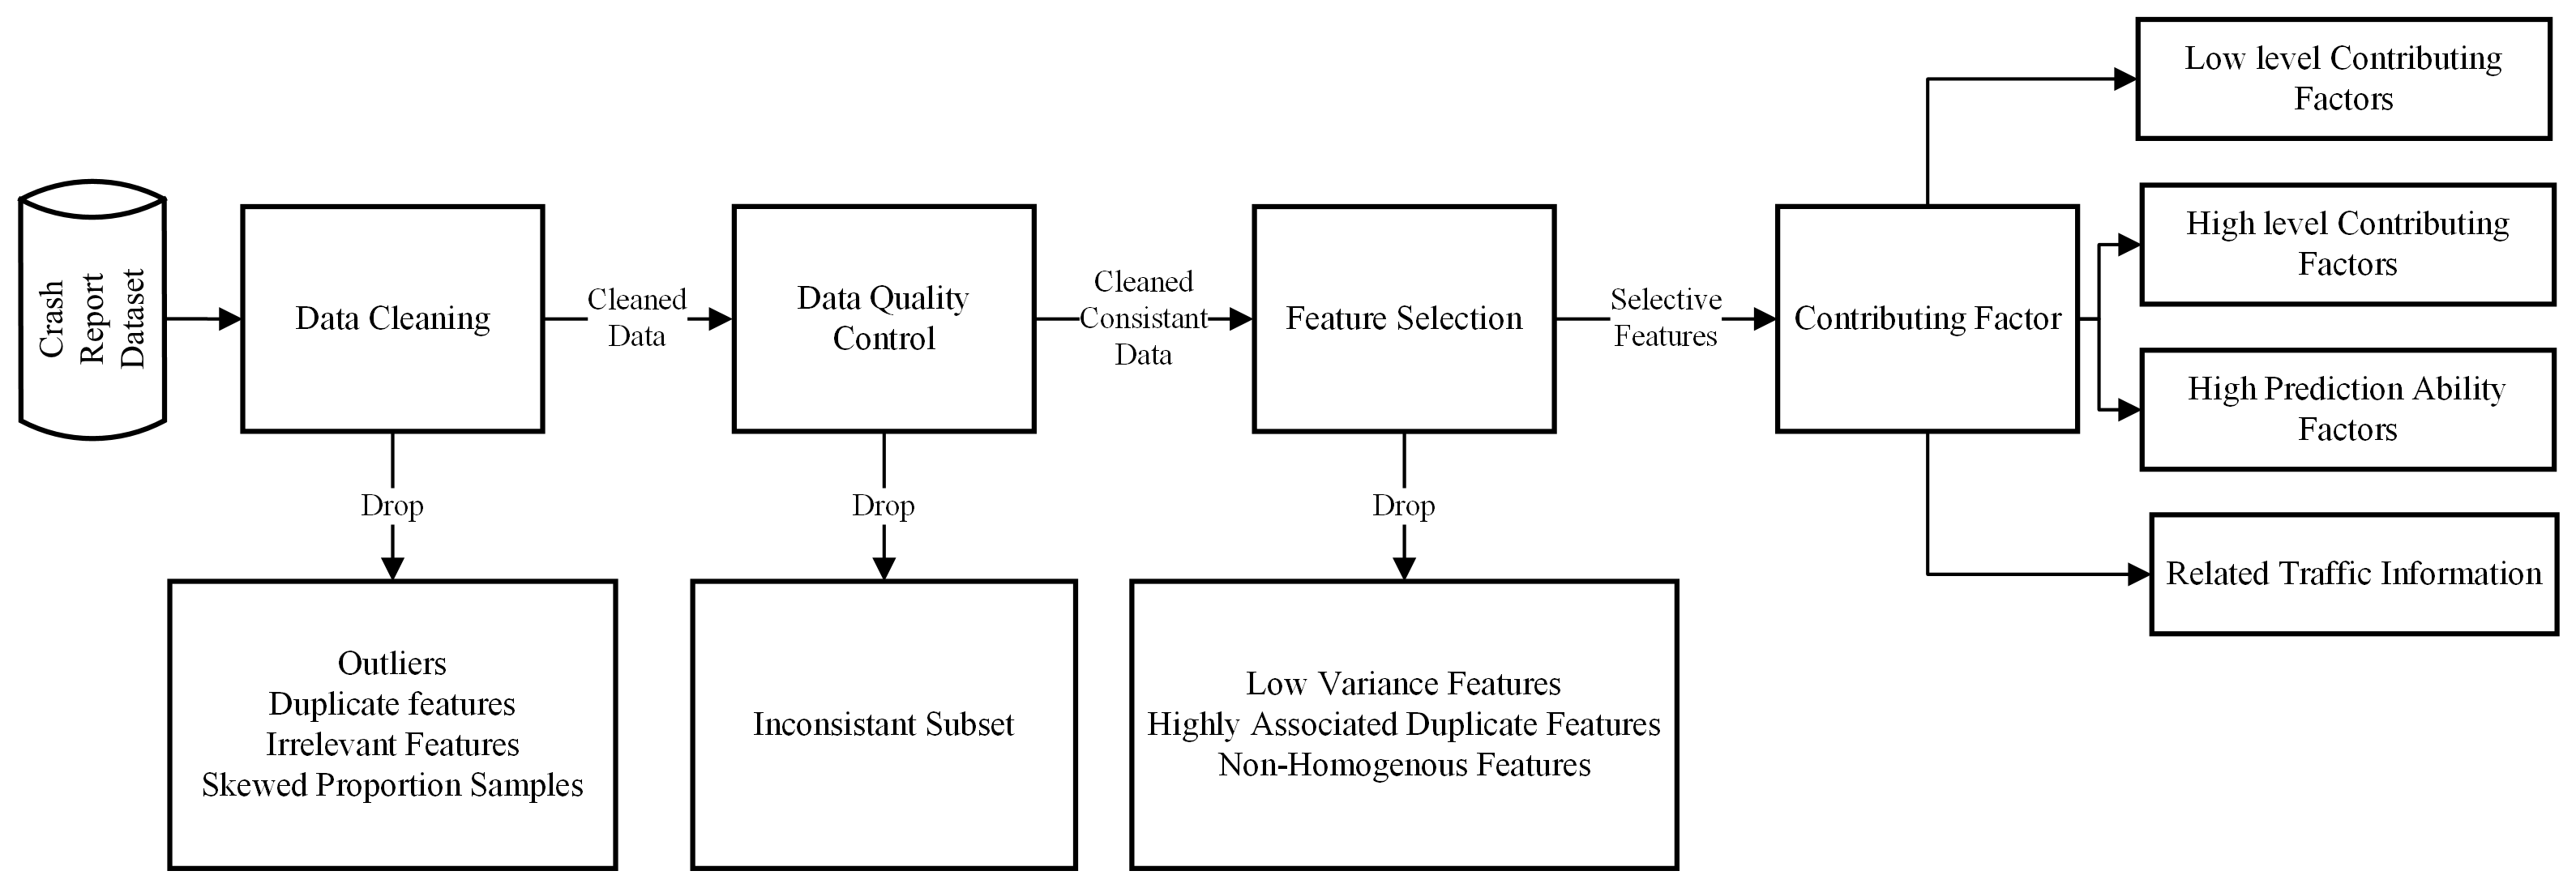

# Requirements

In [ ]:
# General data manipulation
import pandas as pd
import numpy as np

# Progress tracking
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Animation
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from matplotlib import rc
from IPython.display import HTML
from datetime import datetime, timedelta
from copy import deepcopy

# Feature engineering
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder

# Correlation analysis
from dython.nominal import associations

# File handling for saving Excel files
import openpyxl

In [ ]:
## figure setup
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 18
plt.rc('legend',fontsize=16)
my_cmap = plt.get_cmap("viridis")
colors = plt.get_cmap('twilight')(np.linspace(0.1, 0.8, 8))

# Functions

In [ ]:
#% 2. chi-square goodness of fit test

def goodness_of_fit(df, feature, expected_values):
    """
    Performs a goodness-of-fit test to check if the observed data follows a specified distribution.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    feature (str): Column name to test.
    expected_values (pd.Series): Expected value distribution for the feature.

    Returns:
    status (str): Validity of the test (whether assumptions hold).
    observed (pd.Series or None): Observed frequencies of the feature values.
    expected (pd.Series or None): Adjusted expected frequencies.
    """
    # Initialization
    status = 'Test is NOT valid'
    observed = None
    expected = None

    print('H0: The data follow a specified distribution')
    print('HA: The data do not follow the specified distribution')

    # Unique values of the feature (categories)
    unique_values = df[feature].unique()

    # Test validity check: Ensure there are at least 2 unique values
    if unique_values.size < 2:
        return status, observed, expected

    # Setup ranges for splitting
    min_test_size = max(unique_values.size, int(0.05 * len(df)))
    max_test_size = len(df)
    step_size = max(unique_values.size, int(0.0001 * len(df)))

    # Attempt to find a valid split
    for test_size in range(min_test_size, max_test_size, step_size):
        # Split the data randomly
        _, test_data, _, _ = train_test_split(df, df[feature], test_size=test_size / len(df), shuffle=True)

        # Calculate observed frequencies for the feature in the test set
        observed_counts = test_data[feature].value_counts()

        # Check if all unique values are represented
        if observed_counts.index.intersection(unique_values).size == unique_values.size:
            # Filter to keep only common unique values
            observed_counts = observed_counts[unique_values]

            # Check if at least 80% of categories have a frequency >= 5
            if (observed_counts >= 5).sum() > 0.8 * observed_counts.size:
                observed = observed_counts
                expected = deepcopy(observed)

                # Adjust the expected values to match the observed sum
                expected_values_scaled = expected_values * observed.sum() / expected_values.sum()

                status = 'Test is valid'
                return status, observed, expected_values_scaled

    # Return invalid status if conditions are not met
    return status, observed, expected

In [ ]:
#% 2. chi-square independency test

def independency_test(df, feature1, feature2):
    """
    Perform an independence test between two categorical features using the chi-squared test.

    Parameters:
        df (DataFrame): Input DataFrame containing the features.
        feature1 (str): First categorical feature.
        feature2 (str): Second categorical feature.

    Returns:
        status (str): Test result - 'independent', 'dependent', or 'test is NOT valid'.
        batch_size (int): Batch size used for subsampling during the test.
    """
    # Select only the two features of interest
    df_subset = df[[feature1, feature2]]

    # Check for valid feature cardinality (2 to 99 unique values)
    unique_f1 = df_subset[feature1].unique()
    unique_f2 = df_subset[feature2].unique()

    if not (2 <= len(unique_f1) < 100 and 2 <= len(unique_f2) < 100):
        return 'test is NOT valid', None

    # Initialize parameters for batch size exploration
    min_range = int(0.1 * len(df_subset))  # 10% of data size
    max_range = int(0.8 * len(df_subset))  # 80% of data size
    step_size = int(5 * len(unique_f1) * len(unique_f2))

    batch_size = None
    test_valid = False

    # Iteratively sample data batches to check validity
    for i in trange(min_range, max_range, step_size, desc="Testing independence"):
        batch_size = i

        # Perform train-test split with the current batch size
        _, test_data = train_test_split(df_subset, test_size=i / len(df_subset), shuffle=True)

        # Validate sampled data: ensure all unique categories are present
        sampled_f1 = test_data[feature1].unique()
        sampled_f2 = test_data[feature2].unique()

        if set(sampled_f1) != set(unique_f1) or set(sampled_f2) != set(unique_f2):
            continue  # Skip invalid samples

        # Create contingency table for chi-squared test
        contingency_table = pd.DataFrame(index=unique_f1, columns=unique_f2, data=0)

        for value1 in unique_f1:
            for value2 in unique_f2:
                contingency_table.loc[value1, value2] = test_data[
                    (test_data[feature1] == value1) & (test_data[feature2] == value2)
                ].shape[0]

        # Check minimum frequency condition (each cell >= 5)
        if (contingency_table.min().min() < 5):
            continue  # Skip if frequency condition fails

        # Perform chi-squared test
        try:
            p_value = chi2_contingency(contingency_table)[1]  # Get p-value

            if p_value >= 0.05:
                return 'dependent', batch_size
            else:
                return 'independent', batch_size
        except ValueError:
            pass  # Continue if contingency table causes issues

    return 'test is NOT valid', batch_size

In [ ]:
#% 3. chi-square homogenity test
def homogeneity_test_quality_control(df, feature, year=2013, month=7, day=1):
    """
    Perform a homogeneity test on a given feature split before and after a specific date.

    Parameters:
    df (pd.DataFrame): Input dataframe with 'CRASH_DATE' column and the target feature.
    feature (str): The feature to test for homogeneity.
    year (int): Year threshold to split the dataset. Default is 2013.
    month (int): Month threshold to split the dataset. Default is 7.
    day (int): Day threshold to split the dataset. Default is 1.

    Returns:
    str: 'Homogeneous', 'Non-Homogeneous', or 'test is NOT valid'.
    """
    # Ensure the feature has a valid range of unique values
    unique_values = df[feature].nunique()
    if not (2 <= unique_values < 100):
        return "test is NOT valid"

    # Split the data into two subsets based on the date
    threshold_date = datetime(year, month, day)
    df_before = df[df['CRASH_DATE'] < threshold_date]
    df_after = df[df['CRASH_DATE'] > threshold_date]

    # Identify low-frequency categories to exclude
    low_freq_categories = df_before[feature].value_counts()[lambda x: x < 20].index

    # Remove low-frequency categories from df_before
    for category in low_freq_categories:
        df_before = df_before[df_before[feature] != category]

    # Get remaining categories after filtering
    common_categories = df_before[feature].unique()
    if not (2 <= len(common_categories) < 50):
        return "test is NOT valid"

    # Initialize result DataFrame for subsets
    results = pd.DataFrame(index=common_categories, columns=['subset1', 'subset2'])

    # Function to sample and validate subsets
    def sample_subset(df_subset, batch_size, categories):
        """Samples the data and validates category counts."""
        _, sample, _, _ = train_test_split(df_subset, df_subset[df_subset.columns[-1]],
                                           test_size=batch_size / len(df_subset), shuffle=True)
        counts = sample[feature].value_counts()
        return counts.reindex(categories, fill_value=0)

    # Subset 1 Sampling
    done = False
    for size in range(int(0.1 * len(df_before)), int(0.9 * len(df_before)), int(0.1 * len(df_before))):
        subset_counts = sample_subset(df_before, size, common_categories)
        if all(subset_counts >= 5):
            results['subset1'] = subset_counts
            batch_size = size
            done = True
            break

    if not done:
        return "test is NOT valid"

    # Subset 2 Sampling
    subset_counts = sample_subset(df_after, batch_size, common_categories)
    results['subset2'] = subset_counts

    # Perform Chi-Square Test for Homogeneity
    try:
        p_value = chi2_contingency(results.fillna(0))[1]
        return "Homogeneous" if p_value >= 0.05 else "Non-Homogeneous"
    except ValueError:
        return "test is NOT valid"


In [ ]:
#% 4. chi-square homogenity test for feature selection
def homogeneity_test_feature_selection(df, feature):
    """
    Performs a homogeneity test on a given feature to check if subsets of data are homogeneous.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing the feature and 'CRASH_DATE'.
    - feature (str): The feature to be tested.

    Returns:
    - str: 'Homogeneous', 'Non-Homogeneous', or 'test is NOT valid' depending on the outcome.
    """
    # Check if the feature has between 2 and 99 unique values
    unique_values = df[feature].nunique()
    if not (2 <= unique_values < 100):
        return "test is NOT valid"

    # Split the dataset into two equal parts
    subset1, subset2, _, _ = train_test_split(df, df[df.columns[-1]], test_size=0.5, shuffle=True)

    # Filter out rare values (less than 15 occurrences) in subset1
    value_counts = subset1[feature].value_counts()
    rare_values = value_counts[value_counts < 15].index

    for value in rare_values:
        if subset1[feature].nunique() <= 2:
            break
        subset1 = subset1[subset1[feature] != value]

    # Get the common values in the remaining subset1
    common_values = subset1[feature].unique()
    if not (2 <= len(common_values) < 50):
        return "test is NOT valid"

    # Limit to at most 10 unique values
    if len(common_values) > 11:
        common_values = common_values[:10]

    # Initialize a DataFrame to store value counts for both subsets
    homogeneity_df = pd.DataFrame(index=common_values, columns=['subset1', 'subset2'])

    # Perform batch sampling to ensure sufficient counts in subset1
    done = False
    batch_size = 0
    for batch_size in range(int(0.1 * len(subset1)), int(0.9 * len(subset1)), int(0.1 * len(subset1))):
        _, temp_subset1, _, _ = train_test_split(subset1, subset1[subset1.columns[-1]], test_size=batch_size / len(subset1), shuffle=True)
        subset1_counts = temp_subset1[feature].value_counts()

        if set(common_values).issubset(subset1_counts.index) and all(subset1_counts[common_values] > 5):
            done = True
            break

    # Populate 'subset1' counts
    if done:
        for value in common_values:
            homogeneity_df.loc[value, 'subset1'] = subset1_counts.get(value, 0)

        # Perform batch sampling on subset2
        _, temp_subset2, _, _ = train_test_split(subset2, subset2[subset2.columns[-1]], test_size=batch_size / len(subset2), shuffle=True)
        subset2_counts = temp_subset2[feature].value_counts()

        # Populate 'subset2' counts
        for value in common_values:
            homogeneity_df.loc[value, 'subset2'] = subset2_counts.get(value, 0)

        # Perform the chi-squared homogeneity test
        try:
            p_value = chi2_contingency(homogeneity_df).pvalue
            return "Homogeneous" if p_value >= 0.05 else "Non-Homogeneous"
        except ValueError:
            return "test is NOT valid"

    return "test is NOT valid"

In [ ]:
# Define a function to calculate and plot annual crash counts
def plot_annual_crashes(df_animal, label, color, ylim=None):
    """
    Calculate and plot the annual crash counts for a given dataset.

    Parameters:
    - df_animal: DataFrame containing crash data for a specific animal group
    - label: Label for the plot legend
    - color: Bar color for the plot
    - ylim: (Optional) y-axis limit for the plot
    """
    # Calculate annual crash counts
    df_crash_interval = pd.DataFrame(columns=['CRASH_NUMBER'])
    for year in range(2005, 2023):
        start_date = datetime(year, 1, 1)
        end_date = datetime(year + 1, 1, 1)
        df_crash_interval.loc[year, 'CRASH_NUMBER'] = df_animal[
            df_animal['CRASH_DATE'].between(start_date, end_date)
        ].shape[0]

    # Plot annual crash counts
    fig, ax = plt.subplots(figsize=(15, 5))
    X = range(df_crash_interval.index.size)
    Y = df_crash_interval['CRASH_NUMBER']
    ax.bar(X, Y, label=label, color=color, width=0.3, edgecolor='black')

    # Customize plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Crashes (AVC)')
    ax.set_xticks(X)
    ax.set_xticklabels(df_crash_interval.index)
    if ylim:
        ax.set_ylim(0, ylim)
    ax.legend(loc="upper right")
    plt.show()

# Data Description
1. load crash report dataset
2. animal type distribution in the dataset
3. data size
4. data features: pie chart animation
5. feature type

In [ ]:
# Load crash report datasets
deer_path = '/content/drive/MyDrive/AVC/code/data/ND_DeerCollisions.xlsx'
large_game_path = '/content/drive/MyDrive/AVC/code/data/ND_OTHLGAMECollisions.xlsx'
small_animal_path = '/content/drive/MyDrive/AVC/code/data/ND_SmallAnimalCollisions.xlsx'

df_deer = pd.read_excel(deer_path, sheet_name='ND_DeerCollisions')
df_large_game = pd.read_excel(large_game_path, sheet_name='ND_OTHLGAMECollisions')
df_small_animal = pd.read_excel(small_animal_path, sheet_name='ND_SmallAnimalCollisions')

In [ ]:
# Replace zero values with NaN to handle missing data consistently
df_deer.replace(0, np.nan, inplace=True)
df_large_game.replace(0, np.nan, inplace=True)
df_small_animal.replace(0, np.nan, inplace=True)

In [ ]:
# Analyze animal type distribution in the dataset
total_samples = df_deer.index.size + df_large_game.index.size + df_small_animal.index.size
print(f"Number of samples by animal type (Total: {total_samples}):")

categories = ['Deer', 'Small Animal', 'Other Large Game']
proportions = [
    100 * df_deer.index.size / total_samples,
    100 * df_small_animal.index.size / total_samples,
    100 * df_large_game.index.size / total_samples
]

labels = [f"{cat} - {round(prop, 1)}%" for cat, prop in zip(categories, proportions)]

# Customize pie chart appearance
colors_pie = ['#003f5c', '#bc5090', '#ffa600']  # Selected color palette

plt.figure(figsize=(8, 6))
plt.pie(proportions, startangle=90, labels=labels, colors=colors_pie, autopct='%1.1f%%')
plt.title('Animal Type Distribution in AVC Dataset', fontsize=16)
plt.show()


In [ ]:
# Analyze dataset size and missing values
df_combined = pd.concat([df_deer, df_small_animal, df_large_game], axis=0, ignore_index=True)

print(f"Total number of features: {df_combined.columns.size}")
print(f"Total number of samples: {df_combined.index.size}")

missing_values_count = df_combined.isnull().sum().sum()
missing_values_percentage = 100 * missing_values_count / df_combined.size
print(f"Missing value proportion: {missing_values_percentage:.2f}%")


In [ ]:
# 4. Visualize data features with pie chart animation

# Configure animation display in Jupyter
rc('animation', html='jshtml')

# Analysis parameters
days_per_frame = 365  # Range of analysis per frame in days
animation_speed_ms = 1000  # Speed of graph updates (ms)
start_date = datetime(2005, 1, 1)
end_date = datetime(2024, 1, 1)

# Filter data for analysis
df_deer_filtered = deepcopy(df_deer[df_deer.CRASH_DATE.between(start_date, end_date)])
df_deer_filtered.fillna('Missing Value', inplace=True)

crash_dates = df_deer_filtered['CRASH_DATE']
start_date = crash_dates.min()
end_date = crash_dates.max().replace(month=start_date.month, day=start_date.day + 1)

# Calculate frames and date intervals
frame_count = (end_date - start_date).days // days_per_frame + 1
date_intervals = np.array([start_date + timedelta(days=days_per_frame * i) for i in range(frame_count)])

# Prepare data for animation
feature_data = {}
attribute = 'CRASH_DAY'  # Attribute to analyze

# Normalize and calculate percentage
for i in range(len(date_intervals) - 1):
    subset_data = df_deer_filtered[df_deer_filtered['CRASH_DATE'].between(date_intervals[i], date_intervals[i + 1])]
    value_counts = subset_data[attribute].value_counts(normalize=True) * 100
    feature_data[i] = value_counts.reindex(value_counts.index, fill_value=0.0)

# Create animation
fig, ax = plt.subplots()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
fig.set_tight_layout(True)
fig.suptitle(f"{attribute} from {start_date.date()} to {end_date.date()}", fontsize=10, y=0.95)

def animate(frame):
    ax.clear()
    values, labels = feature_data[frame].values, feature_data[frame].index
    truncated_labels = [label[:5] + '..' if isinstance(label, str) and len(label) > 5 else label for label in labels]
    ax.pie(values, labels=truncated_labels, startangle=90, colors=sns.color_palette('Set2'))
    total_crashes = df_deer_filtered.loc[df_deer_filtered['CRASH_DATE'].between(date_intervals[frame], date_intervals[frame + 1])].shape[0]
    ax.set_title(f"{date_intervals[frame].date()} - {date_intervals[frame+1].date()}\nTotal crashes: {total_crashes}", pad=60)
    fig.legend(truncated_labels, loc="lower right", fontsize='small')

animation = FuncAnimation(fig, animate, frames=len(feature_data), blit=False, repeat=True, interval=animation_speed_ms)
plt.close()
animation


In [ ]:
# 5. Analyze feature types
feature_type_path = '/content/drive/MyDrive/AVC/code/data/Feature Type.xlsx'

# Load feature type dataset
df_features = pd.read_excel(feature_type_path, index_col='FEATURE')
df_features.dropna(axis=1, how='all', inplace=True)

# Count occurrences of each feature type
feature_type_counts = df_features['TYPE'].value_counts()
feature_type_counts

# Data Cleaning
1. outlier
2. duplicate
3. skewed proportion samples
4. missing values



In [ ]:
# Combine datasets into a single DataFrame for cleaning
df_total = pd.concat([df_deer, df_small_animal, df_large_game], axis=0, ignore_index=True)

In [ ]:
# Calculate missing value percentage
missing_val_percentage = 100 * df_total.isnull().sum().sum() / df_total.size
print(f"Percentage of missing values: {missing_val_percentage:.2f}%")


In [ ]:
# 1. Outlier Detection and Removal
initial_sample_count = df_total.index.size

# Filter data by date
df_total = df_total[df_total['CRASH_DATE'] >= '2005-01-01'].reset_index(drop=True)

# Define coordinates for North Dakota boundary
nd_boundary = np.array([
    [49.000025, -104.048582],
    [45.945307, -104.045549],
    [45.935239, -96.563687],
    [49.000461, -97.229003],
    [49.000025, -104.048582]
])

# Mark points within the boundary
df_total['color'] = 'red'
for i in df_total.index:
    y_boundary = (
        -1 * (-96.563687 + 97.229003) / (45.935239 - 49.000461) *
        (df_total.loc[i, "LONGITUDE"] - 49.000461) + 97.229003
    )
    if (
        min(nd_boundary[:, 1]) < df_total.loc[i, 'LONGITUDE'] < y_boundary and
        min(nd_boundary[:, 0]) < df_total.loc[i, "LATITUDE"] < max(nd_boundary[:, 0])
    ):
        df_total.loc[i, 'color'] = 'green'

# Retain points marked green and drop the 'color' column
df_total = df_total[df_total['color'] == 'green'].drop(['color'], axis=1)
final_sample_count = df_total.index.size

print(f"Number of features after cleaning: {df_total.columns.size}")
print(f"Number of samples after cleaning: {df_total.index.size}")
print(f"Number of outliers removed: {initial_sample_count - final_sample_count}")


In [ ]:
# 2. Duplicate Feature Removal
df_total = df_total.sort_values(by=['CRASH_DATE']).reset_index(drop=True)

# Define lists of unwanted and duplicate columns
unwanted_columns = [
    'OBJECTID', 'CRASH_NO', 'AGENCY_REP', 'AGENCY_DES', 'FUNC_CLASS', 'NHS',
    'HUND_MILES', 'FROM_NODE', 'FROM_FEET', 'TO_INTERSE', 'DIR_OF_TRA',
    'OP_CITY_D1', 'OTHER_PROP'
]

duplicate_columns = [
    'COUNTY', 'FIRST_HARM', 'OBSERVATIO', 'AGENCY_TYP', 'LIGHT', 'CITY',
    'REPORT_TYP', 'CRASH_TYPE', 'ACCESS_CNT', 'WEATHER', 'RELATION_T',
    'ROAD_COND', 'SURFACE_CO', 'RELATION_2', 'CRASH_SEVE', 'INTER_TYPE',
    'MANNER_OF_', 'SURFACE_TY', 'ROAD_GEOM', 'HUND_KILOM', 'FROM_METER',
    'CRASH_TIME', 'TIME_POLIC', 'POSTED_PRO', 'CRASH_VALI', 'YOUNG_DRIV'
]

# Drop specified columns
df_total.drop(columns=unwanted_columns + duplicate_columns, inplace=True)

print(f"Number of features removed (unwanted): {len(unwanted_columns)}")
print(f"Number of features removed (duplicates): {len(duplicate_columns)}")


In [ ]:
# 3. Address skewed proportions - Multi-vehicle crashes
two_vehicle_count = df_total['DIR_OF_T_1'].notnull().sum()
three_vehicle_count = df_total['DIR_OF_T_2'].notnull().sum()

print(f"AVC involving two vehicles: {two_vehicle_count}")
print(f"AVC involving three vehicles: {three_vehicle_count}")

# Columns related to additional vehicles
multi_vehicle_columns = [
    'UNIT_CON_1', 'DIR_OF_T_1', 'TRAFFIC__1', 'VEH_MOVE_1', 'MOST_HAR_1',
    'OP_AGE_D2', 'OP_SEX_D2', 'OP_CITY_D2', 'OP_STATE_1', 'ALCOHOL__1',
    'SAFETY_E_1', 'CONTRIB__1', 'CITATION_1', 'EJECT_EX_1', 'SPEED_LI_1',
    'VISUAL_O_1', 'UNIT_CON_2', 'DIR_OF_T_2', 'TRAFFIC__2', 'VEH_MOVE_2',
    'MOST_HAR_2', 'OP_AGE_D3', 'OP_SEX_D3', 'OP_CITY_D3', 'OP_STATE_2',
    'ALCOHOL__2', 'SAFETY_E_2', 'CONTRIB__2', 'CITATION_2', 'EJECT_EX_2',
    'SPEED_LI_2', 'VISUAL_O_2'
]

# Calculate and display missing value impact
multi_vehicle_missing = df_total[multi_vehicle_columns].isnull().sum().sum()
total_missing_values = df_total.isnull().sum().sum()
print(f"Impact of multi-vehicle crashes on missing values: {100 * multi_vehicle_missing / total_missing_values:.2f}%")

# Remove rows with multi-vehicle data and related columns
df_total = df_total.drop(df_total[df_total['DIR_OF_T_1'].notnull()].index, axis=0)
df_total.drop(columns=multi_vehicle_columns, inplace=True)

print(f"Number of features after cleaning: {df_total.columns.size}")
print(f"Number of samples after cleaning: {df_total.index.size}")


In [ ]:
# 3. Address skewed proportions - Handle hit-and-run cases
hit_and_run_count = df_total[df_total['HIT_RUN'] == 1].shape[0]

# Remove hit-and-run cases
df_total = df_total[df_total['HIT_RUN'] != 1]
df_total.drop(columns=['HIT_RUN'], inplace=True)
df_total.reset_index(drop=True, inplace=True)

# Results
print(f"Number of hit-and-run samples removed: {hit_and_run_count}")


In [ ]:
#% 3. skwed proportion samples - Filter data for deer-related crashes
df_deer_cleaned = df_total[df_total['FIRST_HA_1'] == 'Deer']
df_deer_cleaned.drop(columns=['FIRST_HA_1'], inplace=True)
df_deer_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
#% 4. missing values
# Impute missing values with descriptive text
for col in df_deer_cleaned.columns:
    df_deer_cleaned[col].fillna(f"{col} Not Reported", inplace=True)


In [ ]:
# Display final dataset stats and save
print(f"Final dataset size: {df_deer_cleaned.index.size} samples, {df_deer_cleaned.columns.size} features")

# Data Quality Control

1. data before and after 2013
2. data in 2013
3. PDO vs injury
4. homogenity test

In [ ]:
#% 1. data before and after 2013

plot_annual_crashes(df_deer, label='Deer', color='tab:blue')
plot_annual_crashes(df_small_animal, label='Small Animal', color='tab:green')
plot_annual_crashes(df_large_game, label='Other Large Game', color='tab:orange', ylim=50)

In [ ]:
#% 2. data during 2013

# Define time range and parameters
start_date = datetime(2012, 12, 31)
current_date = start_date
end_date = datetime(2014, 6, 1)
days_per_week = 7
week_number = 1

# Initialize DataFrame to store weekly crash counts
weekly_crash_counts = pd.DataFrame(columns=['CRASH_COUNT'])

# Calculate weekly crash counts
while current_date < end_date:
    next_date = current_date + timedelta(days=days_per_week)

    # Count crashes within the current week interval
    crash_count = df_deer[df_deer['CRASH_DATE'].between(current_date, next_date)].shape[0]

    # Store crash count with week and year label
    week_label = f"Week {week_number}, {next_date.year}"
    weekly_crash_counts.loc[week_label] = crash_count

    # Reset week number at the end of 2013
    if current_date.year != next_date.year and current_date.year == 2013:
        week_number = 1
    else:
        week_number += 1

    # Move to the next interval
    current_date = next_date

# Plot the weekly crash numbers
fig, ax = plt.subplots(figsize=(20, 5))
x_values = range(weekly_crash_counts.shape[0])
y_values = weekly_crash_counts['CRASH_COUNT']

# Create a bar chart for crash counts
ax.bar(x_values, y_values, width=0.3, label='Deer Crashes', color='tab:blue',
       linewidth=1, edgecolor='black')

# Customize the plot
ax.set_xlabel('\nWeek')
ax.set_ylabel('Number of Crashes (AVC)')
ax.set_ylim(0, 100)

# Set x-tick labels for every 2nd week
x_ticks = range(0, weekly_crash_counts.shape[0], 2)
ax.set_xticks(x_ticks)
ax.set_xticklabels(weekly_crash_counts.index[x_ticks], rotation=90)

plt.legend()
plt.show()

In [ ]:
#% 3. PDO vs Injury

# Define color scheme
colors = plt.get_cmap('twilight')(np.linspace(0.1, 0.8, 8))

# Initialize a DataFrame to store annual crash counts
crash_summary = pd.DataFrame(columns=['PDO', 'Injury'])

# Filter data: 'PDO' crashes and 'Injury' crashes
pdo_crashes = df_deer[df_deer['CRASH_SE_1'] == 'PDO']
injury_crashes = df_deer[df_deer['CRASH_SE_1'] != 'PDO']

# Calculate the number of crashes per year
for year in range(2005, 2023):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year + 1, 1, 1)
    crash_summary.loc[year, 'PDO'] = pdo_crashes[pdo_crashes['CRASH_DATE'].between(start_date, end_date)].shape[0]
    crash_summary.loc[year, 'Injury'] = injury_crashes[injury_crashes['CRASH_DATE'].between(start_date, end_date)].shape[0]

# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))
bar_width = 0.3

# Plot PDO crashes
x_pdo = [i - bar_width / 2 for i in range(len(crash_summary.index))]
ax.bar(x_pdo, crash_summary['PDO'], width=bar_width, color=colors[0], edgecolor='black', label='PDO')

# Plot Injury crashes
x_injury = [i + bar_width / 2 for i in range(len(crash_summary.index))]
ax.bar(x_injury, crash_summary['Injury'], width=bar_width, color=colors[5], edgecolor='black', label='Injury')

# Add labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crashes')
ax.set_title('Annual Comparison of PDO vs Injury Crashes for Deer Incidents')
ax.legend(loc="upper right")

# Set x and y ticks
ax.set_xticks(range(len(crash_summary.index)))
ax.set_xticklabels(crash_summary.index)
ax.set_yticks(range(0, 4001, 1000))

# Show the plot
plt.show()

In [ ]:
#% 4. Homogenity
# Homogeneity Test for Features in Different Subsets

# Homogeneity Test for Features in Different Subsets

# Define subsets of the data based on 'CRASH_SE_1'
dataset = {
    'Total': df_deer.drop(columns=['CRASH_SE_1']),
    'PDO': df_deer[df_deer['CRASH_SE_1'] == 'PDO'].drop(columns=['CRASH_SE_1']),
    'Injury': df_deer[df_deer['CRASH_SE_1'] != 'PDO'].drop(columns=['CRASH_SE_1'])
}

# Initialize Excel file write mode
write_mode = 'w'

# Loop through each subset of the dataset
for key, subset_df in dataset.items():
    print(f"\n### Processing subset: {key} ###")

    # Initialize DataFrame to store homogeneity test results
    homogeneity_results = pd.DataFrame(columns=['Homogeneous', 'Non-Homogeneous', 'Test Not Valid'])

    # Initialize counters
    homogeneous_count = 0
    non_homogeneous_count = 0
    not_valid_count = 0

    # Perform homogeneity test for each feature
    for column in tqdm(subset_df.columns, desc=f"Testing features in {key}"):
        homogeneous, non_homogeneous, not_valid = 0, 0, 0

        for _ in range(100):
            try:
                status = homogeneity_test_quality_control(subset_df, column, year=2013, month=7, day=1)
                if status == 'Homogeneous':
                    homogeneous += 1
                elif status == 'Non-Homogeneous':
                    non_homogeneous += 1
                else:
                    not_valid += 1
            except:
                not_valid += 1

        print(f"Feature '{column}': Homogeneous={homogeneous}, Non-Homogeneous={non_homogeneous}, Not Valid={not_valid}")

        # Record results based on thresholds
        if homogeneous >= 5 and homogeneous >= non_homogeneous:
            homogeneity_results.loc[homogeneous_count, 'Homogeneous'] = column
            homogeneous_count += 1
        elif non_homogeneous >= 5:
            homogeneity_results.loc[non_homogeneous_count, 'Non-Homogeneous'] = column
            non_homogeneous_count += 1
        else:
            homogeneity_results.loc[not_valid_count, 'Test Not Valid'] = column
            not_valid_count += 1

    # Save results to an Excel file
    output_file = '/content/drive/MyDrive/AVC/code/data/homogeneity_test.xlsx'
    with pd.ExcelWriter(output_file, mode=write_mode) as writer:
        homogeneity_results.to_excel(writer, sheet_name=key, index=False)
    write_mode = 'a'

    # Display summary
    print(f"\nSummary for {key}:")
    print(f" - Homogeneous Features: {homogeneous_count}")
    print(f" - Non-Homogeneous Features: {non_homogeneous_count}")
    print(f" - Test Not Valid Features: {not_valid_count}")


#Feature Selection
1. Variance Threshold
2. High Association
3. Homogeniuity

In [ ]:
# Filter data for crashes before 2013
df_deer = df_deer[df_deer['CRASH_DATE'] < datetime(2013, 1, 1)]

# Handle missing values in "OBSER_DESC"
df_deer['OBSER_DESC'].value_counts(normalize=True)

# Categorize age groups into defined ranges
age_groups_na = ['<19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
                 '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85<']
for i in df_deer.index:
    if df_deer.loc[i, 'OP_AGE_D1'] != 'Not Reported':
        temp = 5 * (df_deer.loc[i, 'OP_AGE_D1'] // 5)
        if temp < 20:
            ag = '<19'
        elif temp >= 85:
            ag = '85<'
        else:
            ag = f"{temp}-{temp + 4}"
        df_deer.loc[i, 'OP_AGE'] = ag
df_deer = df_deer.drop(['OP_AGE_D1'], axis=1)

# Impute missing crash hour values with 0
df_deer.loc[df_deer[df_deer['CRASH_HOUR'] == 'Not Reported'].index, 'CRASH_HOUR'] = 0

# Extract date components
df_deer['YEAR'] = df_deer['CRASH_DATE'].dt.year
df_deer['MONTH'] = df_deer['CRASH_DATE'].dt.month
df_deer['DAY'] = df_deer['CRASH_DATE'].dt.day
df_deer = df_deer.drop(['CRASH_DATE', 'DATE_POLIC', 'DATE_ENTER'], axis=1)

In [ ]:
# Feature Selection: Variance Threshold (Low Variance)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder

low_variance_dropped = []
for col in df_deer.columns:
    if df_deer[col].nunique() <= 100:
        encoder = OneHotEncoder()
        encoded = encoder.fit_transform(df_deer[[col]].astype(str))
        try:
            var_thresh = VarianceThreshold(threshold=0.05)
            var_thresh.fit(encoded)
        except ValueError:
            low_variance_dropped.append(col)

df_deer = df_deer.drop(low_variance_dropped, axis=1)
print(f"Dropped {len(low_variance_dropped)} features due to low variance.")

In [ ]:
# Feature Selection: High Association (Correlation)
from dython.nominal import associations

assoc_matrix = associations(df_deer, nom_nom_assoc='theil', plot=False)
correlation_matrix = assoc_matrix['corr']
high_association_dropped = []

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        if col1 != col2 and correlation_matrix.at[col1, col2] >= 0.95:
            high_association_dropped.append(col2)

df_deer = df_deer.drop(high_association_dropped, axis=1)
print(f"Dropped {len(high_association_dropped)} features due to high association.")


In [ ]:
# Initializing column mappings for renaming and reorganization
original_columns = ['HIGHWAY', 'YEAR',
    'MONTH', 'CRASH_DAY', 'CRASH_HOUR', 'UNIT_CONFI', 'TRAFFICWAY',
    'EVASIVE_AC', 'OP_SEX_D1', 'OP_STATE_D', 'SAFETY_EQU', 'CONTRIB_FA',
    'SPEED_LIMI', 'OP_AGE'
]

renamed_columns = ['Highway',
    'Year', 'Month', 'Day in Week', 'Hour', 'Vehicle Type',
    'Traffic Way', 'Evasive Action', 'Driver Sex', 'Driving License State',
    'Safety Equipment', 'Underlying Cause', 'Speed Limit', 'Driver Age'
]

final_columns_order = [
    'Underlying Cause', 'Year', 'Month', 'Day in Week', 'Hour', 'Highway',
    'Traffic Way', 'Speed Limit', 'Driver Sex', 'Driver Age', 'Evasive Action',
    'Driving License State', 'Vehicle Type', 'Safety Equipment'
]

# Filter and rename columns
df_d = df_deer.loc[:, original_columns]
df_d.columns = renamed_columns

# Reorganize columns into the final desired order
df_deer = df_d[final_columns_order]

# Calculate feature correlations using Theil's U
im = associations(df_d_final, nom_nom_assoc='theil', plot=False)
df_corr = pd.DataFrame(im['corr'])

# Update matplotlib parameters for better plot aesthetics
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 18
plt.rc('legend', fontsize=16)

# Define color schemes for potential visualizations
my_cmap = plt.get_cmap("viridis")
colors = plt.get_cmap('twilight')(np.linspace(0.1, 0.8, len(final_columns_order)))

print("Column reorganization and correlation analysis completed.")

In [ ]:
# Grouped features based on semantic categories
semantic_groups = {
    'Temporal': ['Year', 'Month', 'Day in Week', 'Hour'],
    'Spatial': ['Highway', 'Traffic Way'],
    'Driver': ['Driver Sex', 'Driver Age', 'Evasive Action', 'Driving License State'],
    'Vehicle': ['Vehicle Type', 'Safety Equipment'],
    'Cause': ['Underlying Cause', 'Speed Limit']
}

# Analyze associations within groups
for group_name, features in semantic_groups.items():
    mean_assoc = df_corr.loc[features, features].mean().mean()
    print(f"Mean association within {group_name} group: {mean_assoc:.2f}")

# Save correlation data for reporting
correlation_path = '/content/drive/MyDrive/AVC/code/data/Feature_Correlation.xlsx'
df_corr.to_excel(correlation_path)
print(f"Correlation matrix saved at {correlation_path}.")

In [ ]:
# Homogeneity Analysis for Features
from tqdm import tqdm

# Initialize counters for summary statistics
overall_homogeneous = 0
overall_non_homogeneous = 0
overall_not_valid = 0

# Create a DataFrame to store the results
non_homogeneous = []

# Iterate through each column to perform the homogeneity test
for col in tqdm(df_deer.columns, desc="Analyzing feature homogeneity"):
    homogeneous_count = 0
    non_homogeneous_count = 0
    not_valid_count = 0

    # Perform the homogeneity test multiple times for statistical confidence
    for _ in range(100):
        status = homogeneity_test_feature_selection(df_deer, col)

        if status == 'Homogeneous':
            homogeneous_count += 1
        elif status == 'Non-Homogeneous':
            non_homogeneous_count += 1
        elif status == 'test is NOT valid':
            not_valid_count += 1

    # Print summary for the current feature
    print(f"Feature: {col} ---> Homogeneous: {homogeneous_count}, Non-Homogeneous: {non_homogeneous_count}, Test Not Valid: {not_valid_count}")
    if non_homogeneous_count < homogeneous_count:
        non_homogeneous.append[col]

df_deer = df_deer.drop(non_homogeneous, axis=1)
print(f"Dropped {len(high_association_dropped)} features due to non-homogeneity.")


In [ ]:
# Save the cleaned dataset
output_path = '/content/drive/MyDrive/AVC/code/data/Feature_Selection.xlsx'
with pd.ExcelWriter(output_path, mode='w') as writer:
    df_deer.to_excel(writer, index=False)

print(f"Dataset has {df_deer.shape[0]} rows and {df_deer.shape[1]} features after data cleaning.")